In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import RobertaForSequenceClassification, AutoTokenizer
from transformers import AdamW,Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import math
import torch.nn as nn
from transformers import AutoModel, get_cosine_schedule_with_warmup
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [2]:
data = pd.read_csv('shopee.txt', delimiter='\t')

In [3]:
data = pd.DataFrame(data)
data_text = data['comment'].values
data_label = data['rating_star'].values
print(data_text.shape)
print(data_label.shape)

(50126,)
(50126,)


In [4]:
data_text = data_text.reshape(-1, 1)
data_label = data_label.reshape(-1, 1)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_imbalanced, y_imbalanced = rus.fit_resample(data_text, data_label)
X_imbalanced = X_imbalanced.ravel()
y_imbalanced = y_imbalanced.ravel()

In [5]:
print(X_imbalanced.shape, y_imbalanced.shape)
y_imbalanced = pd.get_dummies(y_imbalanced)
y_imbalanced_df = pd.DataFrame(y_imbalanced)
X_imbalanced_df = pd.DataFrame(X_imbalanced, columns=['comment'])

# Concatenate the DataFrames
data = pd.concat([y_imbalanced_df, X_imbalanced_df], axis=1)
new_column_names = {1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}
data = data.rename(columns=new_column_names)

(9655,) (9655,)


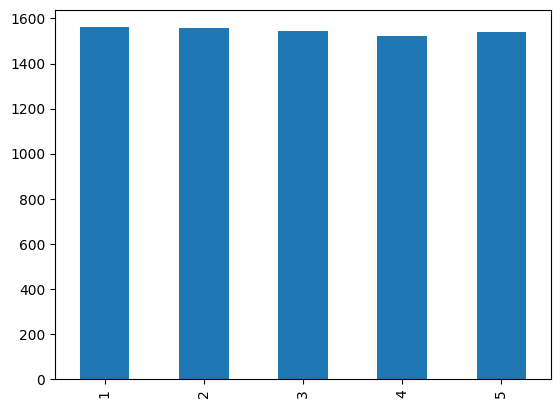

In [6]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=0)
train_data.reset_index(inplace=True, drop=True)
val_data.reset_index(inplace=True, drop=True)
attributes = ['1','2','3','4','5']
train_data[attributes].sum().plot.bar()
plt.show()

In [7]:
model_name = 'wonrax/phobert-base-vietnamese-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer)

PhobertTokenizer(name_or_path='wonrax/phobert-base-vietnamese-sentiment', vocab_size=64000, model_max_length=256, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True)


In [8]:
class review_Dataset(Dataset):
  def __init__ (self, train_data, tokenizer, attributes, max_token_len = 64):
    self.data =  train_data
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len

  def __len__(self):
    return (len(self.data))

  def __getitem__(self, index):
    item = self.data.iloc[index]
    comment = str(item.comment)
    attributes = torch.FloatTensor(item[self.attributes])
    tokens = self.tokenizer.encode_plus(comment,
                                        add_special_tokens =  True,
                                        return_tensors = 'pt',
                                        truncation = True,
                                        max_length = self.max_token_len,
                                        padding = 'max_length' ,
                                        return_attention_mask  = True)
    return {'input_ids':tokens.input_ids.flatten(), 
            'attention_mask': tokens.attention_mask.flatten(),
            'labels': attributes}

In [9]:
review_da = review_Dataset(train_data,tokenizer,attributes)
review_da_val = review_Dataset(val_data, tokenizer, attributes)

In [10]:
review_da.__getitem__(10)

{'input_ids': tensor([    0,  3505,  6992,  4152,  1927, 14598,  1118,   188,   224,  1747,
          3755,  1340, 11142, 13208,     2,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([1., 0., 0., 0., 0.])}

In [11]:
class Review_Data_Module(pl.LightningDataModule):
  def __init__(self, train_data, val_data, attributes, batch_size = 64, max_token_len = 64, model_name = 'wonrax/phobert-base-vietnamese-sentiment'):
    super().__init__()
    self.train_data = train_data
    self.val_data = val_data
    self.attributes = attributes
    self.batch_size = batch_size
    self.max_token_len = max_token_len
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)

  def setup(self, stage = None):
    if stage in (None, "fit"):
      self.train_dataset = review_Dataset(train_data,tokenizer,attributes)
      self.val_dataset = review_Dataset(val_data,tokenizer,attributes)
    if stage == "predict":
      self.val_dataset = review_Dataset(val_data,tokenizer,attributes)
    
  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers = 4, shuffle = True)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers = 4, shuffle = False)

  def predict_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers = 4, shuffle = False)

In [12]:
review_data_module = Review_Data_Module(train_data,val_data,attributes)
review_data_module.setup("fit")
dl = review_data_module.train_dataloader()
len(dl)

121

In [13]:
class Review_Classifier(pl.LightningModule):
  def __init__(self, config:dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'],return_dict = True)
    self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classification = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.hidden.weight)
    torch.nn.init.xavier_uniform_(self.classification.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction= 'mean')
    self.dropout = nn.Dropout()

  def forward(self, input_ids, attention_mask, labels = None):
    #bert model
    output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    #Neral_network_calssification_layers
    pooled_output = self.hidden(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output)
    logits = self.classification(pooled_output)
    #caculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss,logits

  def training_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log('train_loss', loss, on_step = True, on_epoch=True, prog_bar=True)
    preds = torch.sigmoid(logits)
    targets = batch['labels']
    accuracy = ((preds >= 0.5) == targets).sum().float() / targets.numel()
    self.log('train_accuracy', accuracy, on_step = True, prog_bar=True)
    return {"loss": loss, "predictions": logits, "labels": batch['labels']}

  def validation_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger = True)

  def predict_step(self, batch, batch_index):
    _, logits = self(**batch)
    return logits

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['w_decay'])
    total_steps = self.config['train_size'] / self.config['bs']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer],[scheduler]

In [14]:
config = {
    'model_name': 'wonrax/phobert-base-vietnamese-sentiment',
    'n_labels':len(attributes),
    'bs': 64,
    'lr' : 1.5e-6,
    'warmup':0.2,
    'train_size': len(review_data_module.train_dataloader()),
    'w_decay':0.001,
    'n_epochs':25
}
model = Review_Classifier(config)

Some weights of RobertaModel were not initialized from the model checkpoint at wonrax/phobert-base-vietnamese-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
idx = 0
input_ids = review_da.__getitem__(idx)['input_ids']
am = review_da.__getitem__(idx)['attention_mask']
labels = review_da.__getitem__(idx)['labels']
loss,output = model(input_ids.unsqueeze(dim=0),am.unsqueeze(dim=0), labels.unsqueeze(dim=0))

In [16]:
loss, output

(tensor(0.6106, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor([[-0.0594, -0.1227, -0.1078, -0.4194, -0.3100]],
        grad_fn=<AddmmBackward0>))

In [17]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(dirpath='phoBert-shoppe-review.h5',
    filename='my_model',
    save_top_k=1,
    mode='min')
review_data_module = Review_Data_Module(train_data, val_data, attributes, batch_size = config['bs'])
review_data_module.setup()
model = Review_Classifier(config)
trainer = pl.Trainer(max_epochs=config['n_epochs'],num_sanity_val_steps = 25,callbacks = checkpoint_callback)
trainer.fit(model,review_data_module)

Some weights of RobertaModel were not initialized from the model checkpoint at wonrax/phobert-base-vietnamese-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [18]:
def classify_review_comment(model, dm):
    predictions = trainer.predict(model,datamodule = dm)
    flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
    return flattened_predictions

In [19]:
predictions = classify_review_comment(model, review_data_module)

Predicting: 0it [00:00, ?it/s]

In [20]:
print(predictions)

[[0.4717027  0.3442263  0.15804498 0.03041436 0.00818015]
 [0.03356597 0.14309539 0.39888814 0.44355837 0.05541136]
 [0.04216592 0.09437273 0.2888217  0.4956666  0.04212233]
 ...
 [0.13279326 0.32955948 0.3261887  0.1671522  0.01149457]
 [0.0296416  0.10381267 0.31567907 0.5023539  0.05298756]
 [0.61500376 0.27806    0.11893588 0.02577697 0.00879485]]


In [21]:
print(val_data)

          1      2      3      4      5  \
0      True  False  False  False  False   
1     False  False   True  False  False   
2     False  False   True  False  False   
3     False  False   True  False  False   
4      True  False  False  False  False   
...     ...    ...    ...    ...    ...   
1926  False   True  False  False  False   
1927  False  False  False  False   True   
1928  False  False   True  False  False   
1929  False  False   True  False  False   
1930  False   True  False  False  False   

                                                comment  
0                                       Tai nghe chán v  
1     Mũ có chỗ lấm chấm như bị mốc. Nhưng được cái ...  
2     Chưa dùng thử, chưa biết thế nào. Nhìn nhiều n...  
3     Mở hàng ra thốt lên í đây là kẹp tóc của mk nè...  
4     ốp đẹp nhưng giao nhầm màu, mình đặt bạc thì g...  
...                                                 ...  
1926   Đặt xám, trắng thì giao tất cả màu xám hết. Chán  
1927  Giao hàng nha

In [22]:
true_labels = np.array(val_data[attributes])

In [23]:
true_labels

array([[ True, False, False, False, False],
       [False, False,  True, False, False],
       [False, False,  True, False, False],
       ...,
       [False, False,  True, False, False],
       [False, False,  True, False, False],
       [False,  True, False, False, False]])

Text(0.5, 1.0, 'Phobert trained on Review Dataset - AUC ROC')

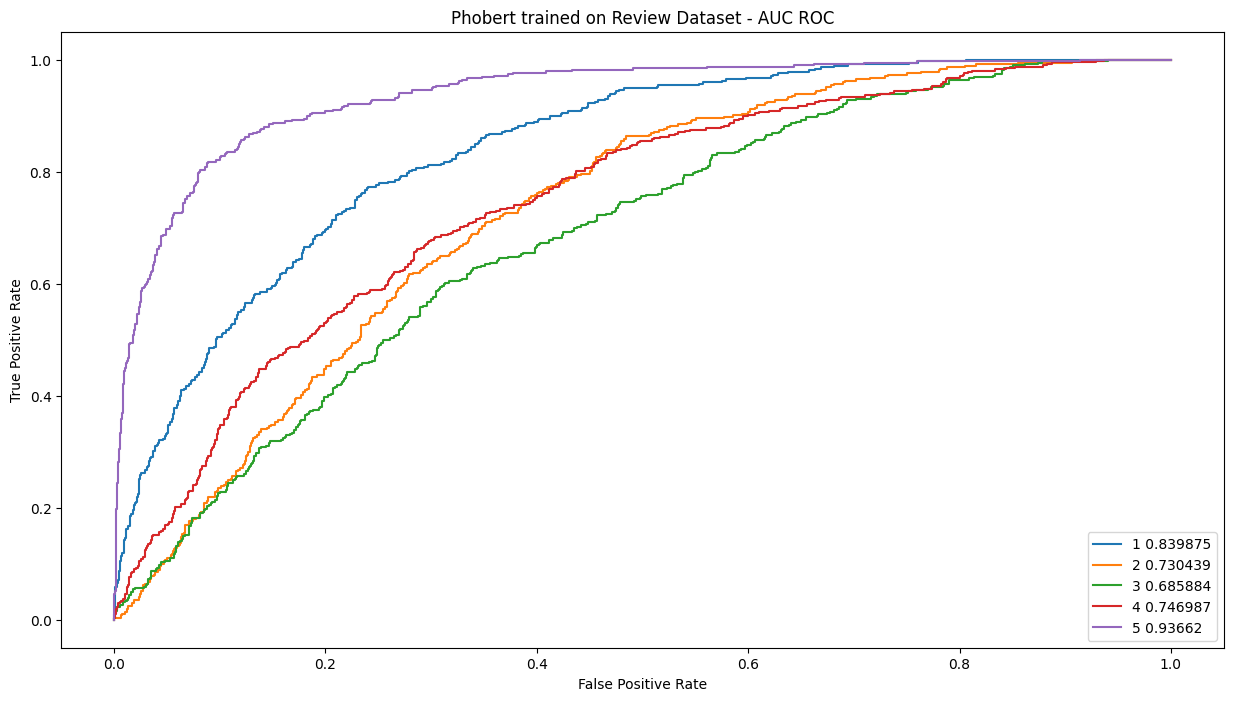

In [24]:
from sklearn import metrics
plt.figure(figsize = (15,8))
for i, attribute in enumerate(attributes):
    fpr, tpr,_ = metrics.roc_curve(
    true_labels[:,i].astype(int), predictions[:,i])
    auc = metrics.roc_auc_score(
    true_labels[:,i].astype(int), predictions[:,i])
    plt.plot(fpr, tpr, label = "%s %g" % (attribute, auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = "lower right")
plt.title('Phobert trained on Review Dataset - AUC ROC')

In [25]:
test = pd.read_csv('/kaggle/input/shopee-reviews/test.txt', delimiter='\t')
test = pd.DataFrame(test)

In [26]:
review_data_module = Review_Data_Module(train_data, test, attributes, batch_size = config['bs'])
review_data_module.setup()

In [27]:
pred_test = classify_review_comment(model, review_data_module)

Predicting: 0it [00:00, ?it/s]

In [28]:
print(pred_test)

[[0.4717027  0.3442263  0.15804498 0.03041436 0.00818015]
 [0.03356597 0.14309539 0.39888814 0.44355837 0.05541136]
 [0.04216592 0.09437273 0.2888217  0.4956666  0.04212233]
 ...
 [0.13279326 0.32955948 0.3261887  0.1671522  0.01149457]
 [0.0296416  0.10381267 0.31567907 0.5023539  0.05298756]
 [0.61500376 0.27806    0.11893588 0.02577697 0.00879485]]


In [29]:
print(test[['rating_star']])

      rating_star
0               1
1               1
2               1
3               1
4               1
...           ...
5505            5
5506            5
5507            5
5508            5
5509            5

[5510 rows x 1 columns]


In [30]:
label_pred = np.argmax(pred_test, axis=1)

In [31]:
print(label_pred)

[0 3 3 ... 1 3 0]


In [34]:
label_pred = np.array(label_pred)
star_avg = np.sum(label_pred + 1) / len(label_pred)
print("Số sao của sản phẩm là:", star_avg)

Số sao của sản phẩm là: 3.0771620921802176
